## Getting the data online

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/sp-500-stocks")

print("Path to dataset files:", path)

/Users/christianvanellnielsen/Library/CloudStorage/OneDrive-Personligt/Documents/Christian/DTU/5. Semester/exam_project_mlops/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 18.7M/18.7M [00:01<00:00, 15.5MB/s]

Extracting files...


Path to dataset files: /Users/christianvanellnielsen/.cache/kagglehub/datasets/andrewmvd/sp-500-stocks/versions/1023


In [10]:
import pandas

data = pandas.read_csv("../data/raw/sp500_companies.csv")
data.columns

Index(['Exchange', 'Symbol', 'Shortname', 'Longname', 'Sector', 'Industry',
       'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State',
       'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight'],
      dtype='object')

# Making the model

## imports

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


## Load data and encode

In [16]:
# Load the dataset (replace 'your_dataset.csv' with your file path)
data = pd.read_csv("../data/raw/sp500_companies.csv")

# Drop unnecessary columns
data = data.drop(columns=['Longbusinesssummary', 'City', 'State', 'Country', 'Shortname', 'Longname'])

# Handle missing values
data = data.dropna()

# Separate features and target
X = data.drop(columns=['Sector'])
y = data['Sector']

# Encode categorical features and target
categorical_features = ['Exchange', 'Symbol', 'Industry']
numerical_features = ['Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'Fulltimeemployees', 'Weight']

# One-hot encode categorical features
column_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

X_transformed = column_transformer.fit_transform(X)

# One-hot encode the target
y_encoded = pd.get_dummies(y).values

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Torch tensors and dataloader

In [18]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
def create_dataloader(X, y, batch_size):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(X_train_tensor, y_train_tensor, batch_size=32)
val_loader = create_dataloader(X_val_tensor, y_val_tensor, batch_size=32)
test_loader = create_dataloader(X_test_tensor, y_test_tensor, batch_size=32)


## The Model

In [19]:
# Define the neural network class
class SectorClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SectorClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.softmax(self.fc3(x), dim=1)
        return x

# Initialize the model
input_size = X_train_tensor.shape[1]
num_classes = y_train_tensor.shape[1]
model = SectorClassifier(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train and evaluate

In [26]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, torch.argmax(y_batch, dim=1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, torch.argmax(y_batch, dim=1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predicted = torch.argmax(outputs, dim=1)
            actual = torch.argmax(y_batch, dim=1)
            correct += (predicted == actual).sum().item()
            total += y_batch.size(0)
    print(f"Test Accuracy: {correct / total:.4f}")

evaluate_model(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'sector_classification_model.pth')

Epoch 1/50, Train Loss: 1.5577, Val Loss: 1.7365
Epoch 2/50, Train Loss: 1.5534, Val Loss: 1.7168
Epoch 3/50, Train Loss: 1.5510, Val Loss: 1.6676
Epoch 4/50, Train Loss: 1.5495, Val Loss: 1.7203
Epoch 5/50, Train Loss: 1.5494, Val Loss: 1.7259
Epoch 6/50, Train Loss: 1.5490, Val Loss: 1.6668
Epoch 7/50, Train Loss: 1.5493, Val Loss: 1.6600
Epoch 8/50, Train Loss: 1.5479, Val Loss: 1.7126
Epoch 9/50, Train Loss: 1.5493, Val Loss: 1.6601
Epoch 10/50, Train Loss: 1.5492, Val Loss: 1.6567
Epoch 11/50, Train Loss: 1.5463, Val Loss: 1.7112
Epoch 12/50, Train Loss: 1.5459, Val Loss: 1.6688
Epoch 13/50, Train Loss: 1.5479, Val Loss: 1.6611
Epoch 14/50, Train Loss: 1.5465, Val Loss: 1.6728
Epoch 15/50, Train Loss: 1.5470, Val Loss: 1.6572
Epoch 16/50, Train Loss: 1.5512, Val Loss: 1.7089
Epoch 17/50, Train Loss: 1.5509, Val Loss: 1.6625
Epoch 18/50, Train Loss: 1.5455, Val Loss: 1.6620
Epoch 19/50, Train Loss: 1.5465, Val Loss: 1.7113
Epoch 20/50, Train Loss: 1.5455, Val Loss: 1.6563
Epoch 21/

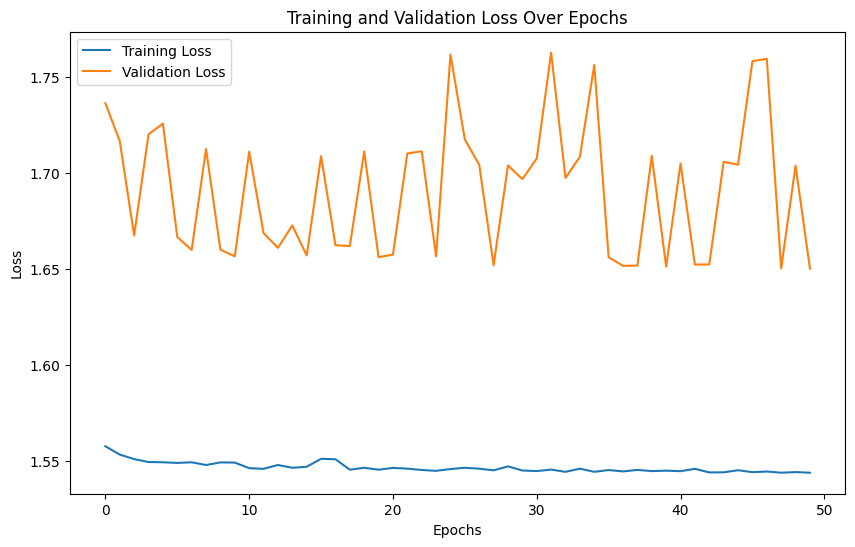

In [27]:
# Visualize training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Prediction of unseen company

In [28]:
# Function to predict the sector of a new company
def predict_sector(model, input_data):
    model.eval()
    input_tensor = torch.tensor(input_data, dtype=torch.float32)
    with torch.no_grad():
        output = model(input_tensor)
        predicted_index = torch.argmax(output, dim=1).item()
    return predicted_index

# Example: Predict sector for a new company with raw input
def preprocess_new_company(raw_data):
    # Convert raw_data to a DataFrame
    raw_df = pd.DataFrame([raw_data], columns=['Exchange', 'Symbol', 'Industry', 'Currentprice', 'Marketcap', 
                                               'Ebitda', 'Revenuegrowth', 'Fulltimeemployees', 'Weight'])
    # Apply transformations
    transformed_data = column_transformer.transform(raw_df).toarray()
    return transformed_data

# Template for new company input
new_company_raw = {
    'Exchange': 'NASDAQ',  # Example: 'NASDAQ'
    'Symbol': 'AAPL',      # Example: 'AAPL'
    'Industry': 'Technology', # Example: 'Technology'
    'Currentprice': 150.0, # Example: numerical value
    'Marketcap': 2500000000000, # Example: numerical value
    'Ebitda': 80000000000,  # Example: numerical value
    'Revenuegrowth': 0.05,  # Example: numerical value
    'Fulltimeemployees': 154000, # Example: numerical value
    'Weight': 0.01          # Example: numerical value
}

# Preprocess the input data
new_company_transformed = preprocess_new_company(new_company_raw)

# Predict sector
sector_index = predict_sector(model, new_company_transformed)
sector_name = pd.get_dummies(y).columns[sector_index]
print(f"Predicted Sector: {sector_name}")


Predicted Sector: Communication Services
